# Learning to Train with the New SPK
A few APIs have changed for the better

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
from fff.learning.spk import ase_to_spkdata
from schnetpack import train as trn
import schnetpack as spk
from pathlib import Path
from random import shuffle
from tqdm import tqdm
from ase.db import connect
import pandas as pd
import shutil
import torch

/lambda_stor/homes/lward/fast-finedtuned-forcefields/env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Create the Data Loader
We'll connect to the dataset I made via an external script and use the "same data" 

Load in the initial training set and convert it to spk training data

In [2]:
with connect('../initial-database/initial-psi4-631g.db') as db:
    all_strcs = [a.toatoms() for a in db.select('')]
shuffle(all_strcs)

Save the first 10% as validation

In [3]:
data_dir = Path('data')
if data_dir.exists():
    shutil.rmtree(data_dir)
data_dir.mkdir()

In [4]:
cut = len(all_strcs) // 10

In [5]:
val_data = ase_to_spkdata(all_strcs[:cut], 'data/valid.db')

In [6]:
data = ase_to_spkdata(all_strcs[cut:], 'data/train.db')

Make the laoders

In [7]:
loader = spk.AtomsLoader(data, batch_size=64, shuffle=True, num_workers=8, drop_last=True, pin_memory=True)

In [8]:
val_loader = spk.AtomsLoader(val_data, batch_size=64, num_workers=8, pin_memory=True)

## Load the Model
Get the one we've already converted

In [9]:
model = torch.load('starting-psi4-model', map_location='cuda')

## Train the model
Use both the energy and the forces

First define the loss function

In [10]:
if Path('test').exists():
    shutil.rmtree('test')

In [11]:
# tradeoff
rho_tradeoff = 0.9

# loss function
def loss(batch, result):
    # compute the mean squared error on the energies
    diff_energy = batch['energy']-result['energy']
    err_sq_energy = torch.mean(diff_energy ** 2)

    # compute the mean squared error on the forces
    diff_forces = batch['forces']-result['forces']
    err_sq_forces = torch.mean(diff_forces ** 2)

    # build the combined loss function
    err_sq = rho_tradeoff*err_sq_energy + (1-rho_tradeoff)*err_sq_forces

    return err_sq

Now the optimizer

In [12]:
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

Now the training metrics

In [13]:
# set up metrics
metrics = [
    spk.metrics.MeanAbsoluteError('energy'),
    spk.metrics.MeanAbsoluteError('forces')
]

# construct hooks
hooks = [
    trn.CSVHook(log_path='test', metrics=metrics),
    trn.ReduceLROnPlateauHook(
        optimizer,
        patience=8, factor=0.8, min_lr=1e-6,
        stop_after_min=True
    )
]

Run the fitting

In [14]:
trainer = trn.Trainer(
    model_path='test',
    model=model,
    hooks=hooks,
    loss_fn=loss,
    optimizer=optimizer,
    train_loader=loader,
    validation_loader=loader,
)

In [15]:
trainer.train(device='cuda', n_epochs=1024)

## Plot the Learning Curve
Show how the accuracy improves with training

In [16]:
train_log = pd.read_csv('test/log.csv')

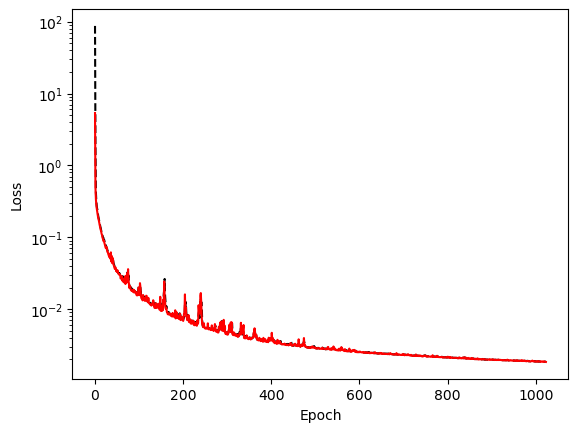

In [17]:
fig, ax = plt.subplots()

ax.plot(train_log['Train loss'], 'k--', label='Train')
ax.plot(train_log['Validation loss'], 'r-', label='Validation')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_yscale('log')

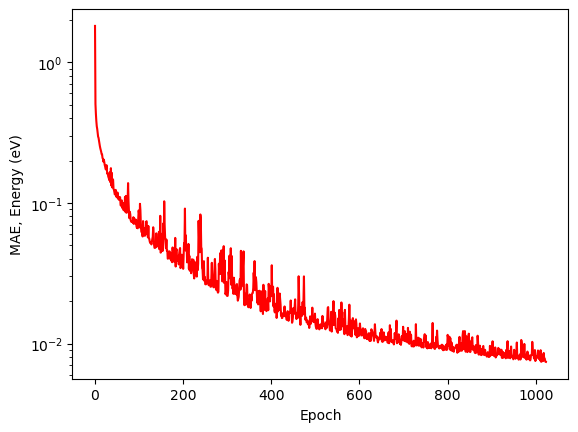

In [18]:
fig, ax = plt.subplots()

ax.plot(train_log['MAE_energy'], 'r-', label='Train')

ax.set_xlabel('Epoch')
ax.set_ylabel('MAE, Energy (eV)')
ax.set_yscale('log')